In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
import scipy as sp
from sklearn.linear_model import LinearRegression

In [ ]:
participant_data = pd.read_csv('/redacted/path/demographics.csv')
age = np.array(participant_data.age)
sex = np.array(participant_data.sex)
participantid = np.array(participant_data.ID)

In [ ]:
metrics = ['fneurite','fsoma','fe','R','ODI','b500_1200_MD']
hemi = ['L','R']
metrichold = np.empty((7262,2,len(participantid),len(metrics)))

### Load all surface data

In [ ]:
for ii in range(len(participantid)):
    for jj in range(len(hemi)):
        for kk in range(len(metrics)):
            if metrics[kk] == 'ODI':
                metrichold[:,jj,ii,kk] = nib.load(f'/redacted/path/NODDI/sub-{participantid[ii]}/midsurf/sub-{participantid[ii]}_hemi-{hemi[jj]}_space-T1w_den-0p5mm_label-hipp_midthickness_desc-{metrics[kk]}.shape.gii').agg_data()                   
            elif metrics[kk] == 'b500_1200_MD':
                metrichold[:,jj,ii,kk] = nib.load(f'/redacted/path/DTI/sub-{participantid[ii]}/DTI_b500_1200/midsurf/sub-{participantid[ii]}_hemi-{hemi[jj]}_space-T1w_den-0p5mm_label-hipp_midthickness_desc-{metrics[kk]}.shape.gii').agg_data()     
            else: 
                metrichold[:,jj,ii,kk] = nib.load(f'/redacted/path/SANDI/sub-{participantid[ii]}/midsurf/sub-{participantid[ii]}_hemi-{hemi[jj]}_space-T1w_den-0p5mm_label-hipp_midthickness_desc-{metrics[kk]}.shape.gii').agg_data()

### Average within subfields

In [ ]:
# Note that the subfield surface labels are the same across all participants

subholdL = nib.load(f'/redacted/path/sub-{participantid[ii]}_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-bigbrain_subfields.label.gii').agg_data()
subholdR = nib.load(f'/redacted/pathsub-{participantid[ii]}_hemi-R_space-T1w_den-0p5mm_label-hipp_atlas-bigbrain_subfields.label.gii').agg_data()

subfieldnum = [1,2,3,4,5]
subfieldlabel = ['Subiculum','CA1','CA2','CA3','DG/CA4']

metricsubfavg = np.empty((len(hemi),len(participantid),len(metrics),len(subfieldnum)))


for ii in range(len(subfieldnum)):
    subLind = subholdL == subfieldnum[ii]
    subRind = subholdR == subfieldnum[ii]

    metricsubfavg[0,:,:,ii] = np.mean(metrichold[subLind,0,:,:],axis=0)
    metricsubfavg[1,:,:,ii] = np.mean(metrichold[subRind,1,:,:],axis=0)

### Make dataframe

In [8]:
dL = {}
dR = {}
for ii in range(len(metrics)):
    dL[metrics[ii]] = metricsubfavg[0,:,ii,:].flatten(order='F')
    dR[metrics[ii]] = metricsubfavg[1,:,ii,:].flatten(order='F')


dL['age'] = np.tile(age,5)
dL['participantid'] = np.tile(participantid,5)
dL['sex'] = np.tile(sex,5)
dL['hemi'] = np.repeat(hemi[0],88*5)

dR['age'] = np.tile(age,5)
dR['participantid'] = np.tile(participantid,5)
dR['sex'] = np.tile(sex,5)
dR['hemi'] = np.repeat(hemi[1],88*5)

label = np.empty((88*5))
label[0:88] = 1
label[88:88*2] = 2
label[88*2:88*3] = 3
label[88*3:88*4] = 4
label[88*4:88*5] = 5
dL['subfield'] = label
dR['subfield'] = label

label = np.empty((88*5),dtype=object)
label[0:88] = 'subiculum'
label[88:88*2] = 'CA1'
label[88*2:88*3] = 'CA2'
label[88*3:88*4] = 'CA3'
label[88*4:88*5] = 'DG/CA4'
dL['subfield_labels'] = label
dR['subfield_labels'] = label

dfL = pd.DataFrame(data=dL)
dfR = pd.DataFrame(data=dR)

frames = [dfL, dfR]

dfcomb = pd.concat(frames)

In [ ]:
dfplot = pd.melt(dfcomb,id_vars=['age','subfield','participantid','sex','hemi','subfield_labels'])

### Averaging hemispheres

In [ ]:
df = {}
for ii in range(len(metrics)):
    df[metrics[ii]] = np.mean(metricsubfavg[:,:,ii,:],axis=0).flatten(order='F')


df['age'] = np.tile(age,5)
df['participantid'] = np.tile(participantid,5)
df['sex'] = np.tile(sex,5)

label = np.empty((88*5))
label[0:88] = 1
label[88:88*2] = 2
label[88*2:88*3] = 3
label[88*3:88*4] = 4
label[88*4:88*5] = 5
df['subfield'] = label

label = np.empty((88*5),dtype=object)
label[0:88] = 'subiculum'
label[88:88*2] = 'CA1'
label[88*2:88*3] = 'CA2'
label[88*3:88*4] = 'CA3'
label[88*4:88*5] = 'DG/CA4'
df['subfield_labels'] = label

dfcomb = pd.DataFrame(data=df)

### This is the data in the dataset excel sheet provided with the manuscript

In [ ]:
dfplot = pd.melt(dfcomb,id_vars=['age','subfield','participantid','sex','subfield_labels'])

([<matplotlib.axis.XTick at 0x7f4074b53610>,
 [Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18')])

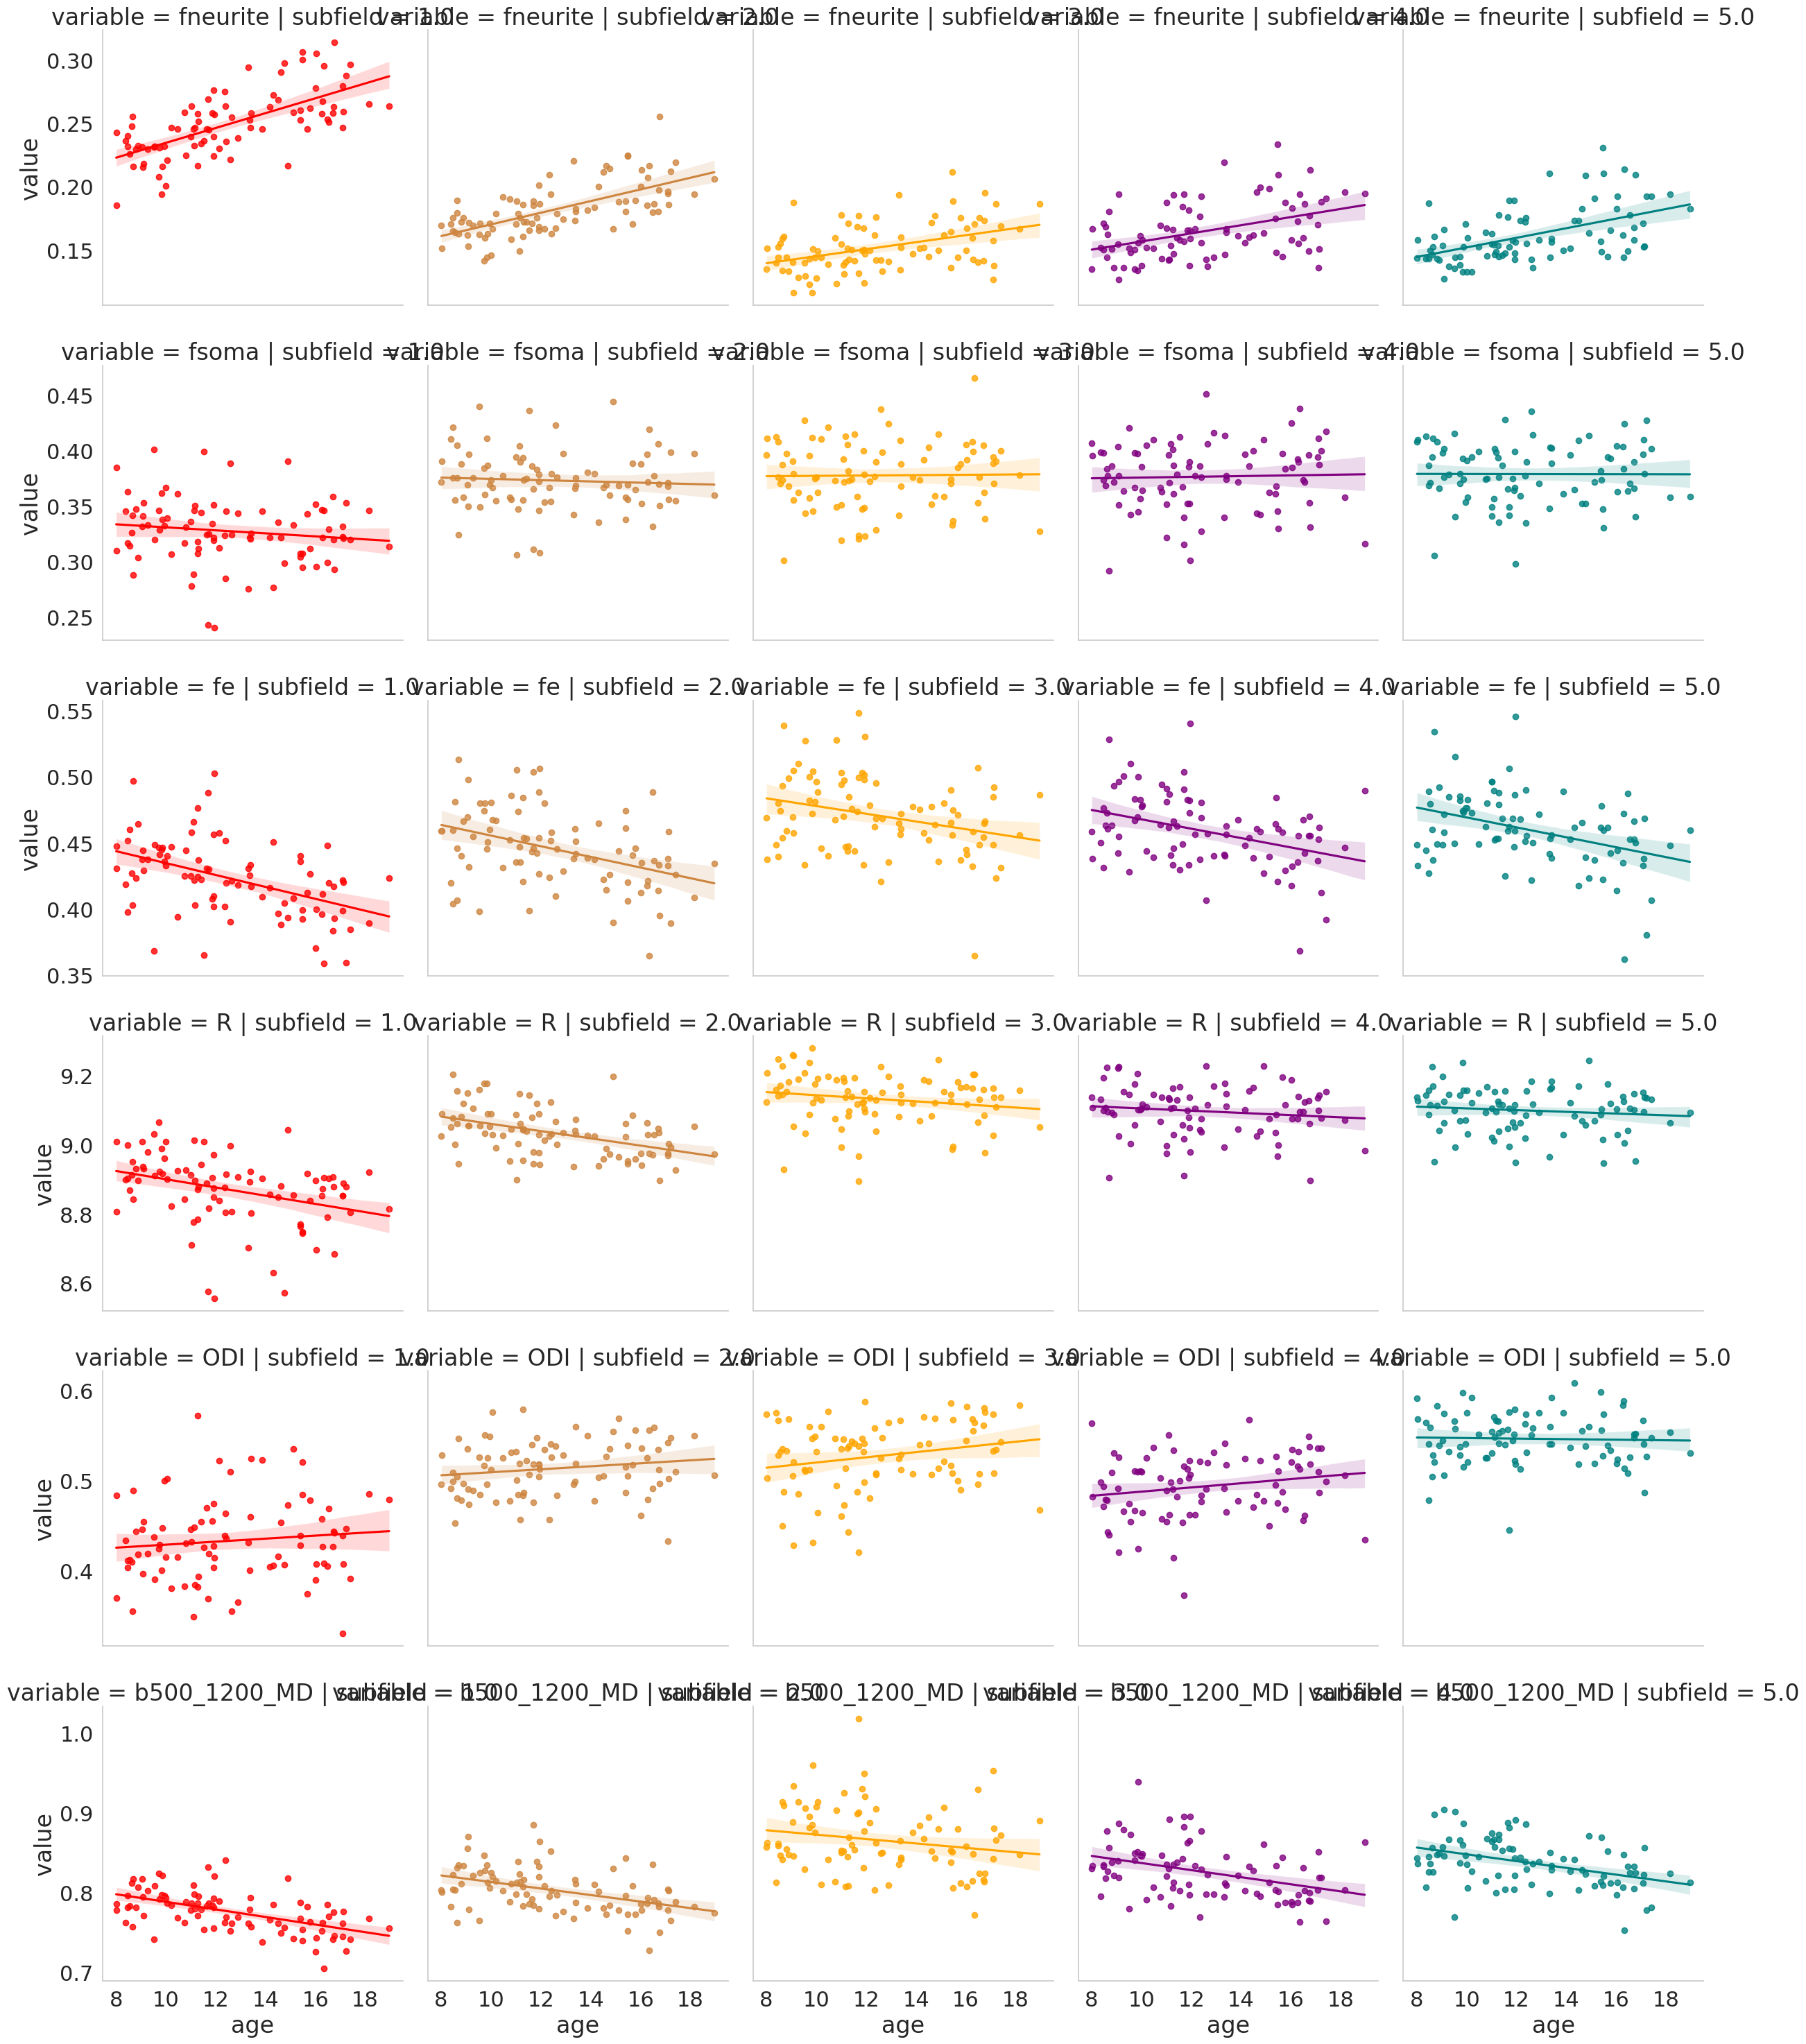

In [ ]:
flatui = ["red","peru", "orange","purple","teal"]
sns.set_palette(sns.color_palette(flatui))
palette=sns.color_palette(flatui)

sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})

lm = sns.lmplot(x="age", y='value', data=dfplot,row='variable',col='subfield',hue='subfield',palette=palette,order=1,facet_kws={'sharey':'row','sharex':True})
plt.xticks([8,10,12,14,16,18]) 


### Pearson's R across age

In [ ]:
metrics = ['fneurite','fsoma','fe','R','ODI','b500_1200_MD']

Rhold = np.empty((5,len(metrics)))
phold = np.empty((5,len(metrics)))
labels = ['Sub','CA1','CA2','CA3','DG/CA4']

for ii in range(5):
    for jj in range(len(metrics)):
        Y = dfcomb[dfcomb['subfield']==ii+1][metrics[jj]]
        X = dfcomb[dfcomb['subfield']==ii+1]['age']
        corr = sp.stats.pearsonr(X,Y)
        Rhold[ii,jj]= corr[0]
        phold[ii,jj]= corr[1]

<Axes: >

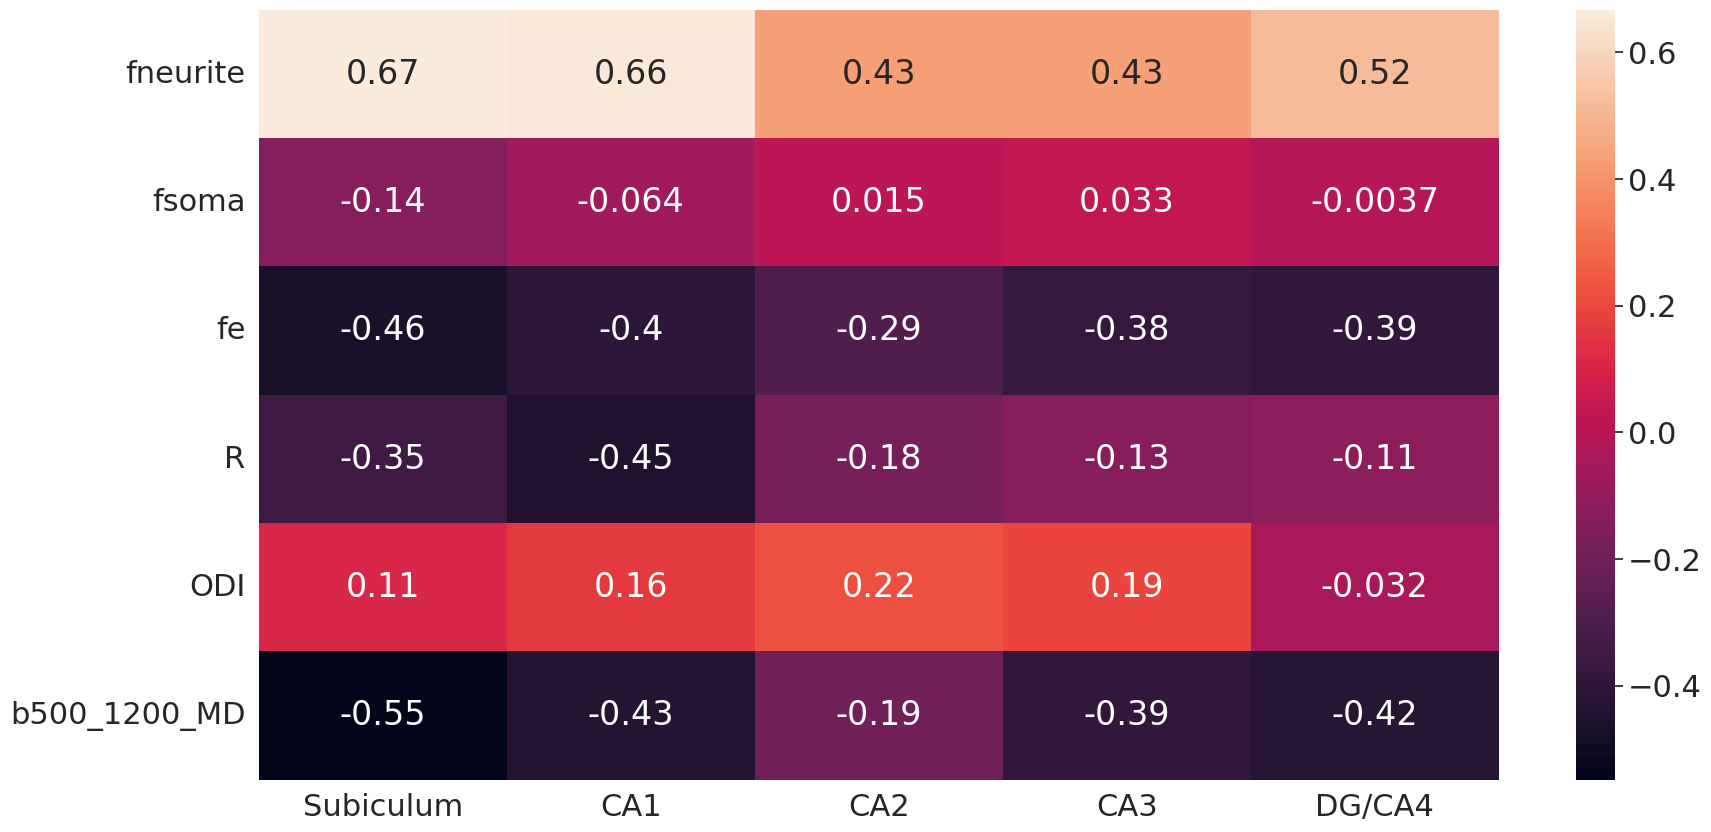

In [24]:
fig, ax = plt.subplots(figsize=(20,10))

Rdf = pd.DataFrame(Rhold.T)

sns.heatmap(Rdf,annot=True,yticklabels=metrics,xticklabels=subfieldlabel)

### p-value of Pearson's R (is R sig. > 0)

<Axes: >

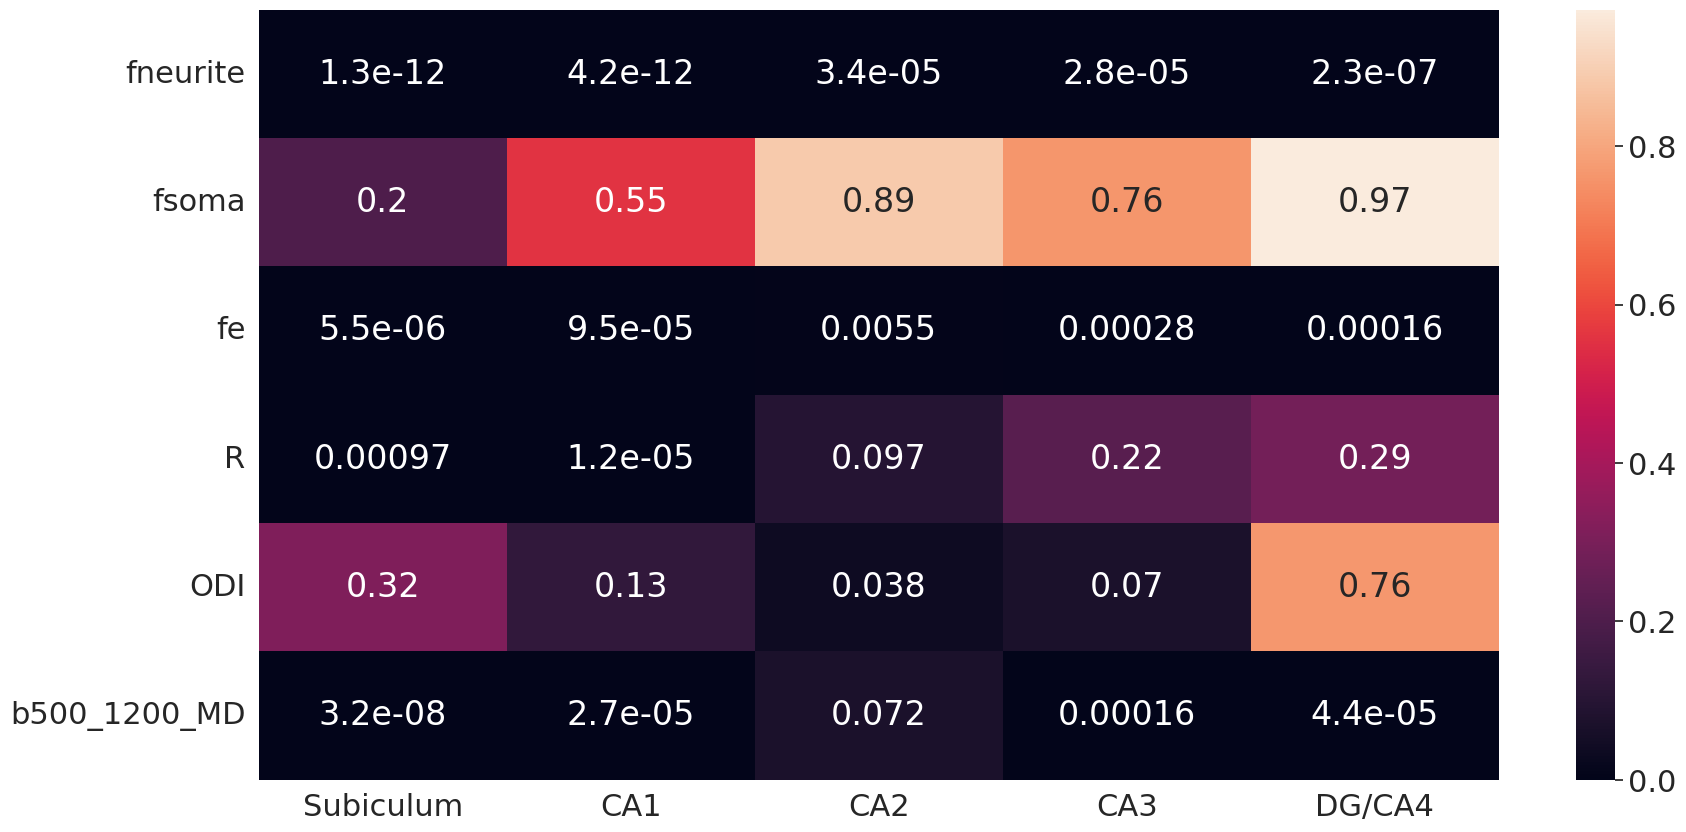

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
pval = pd.DataFrame(phold.T)
sns.heatmap(pval,annot=True,yticklabels=metrics,xticklabels=subfieldlabel)

### Sex analysis

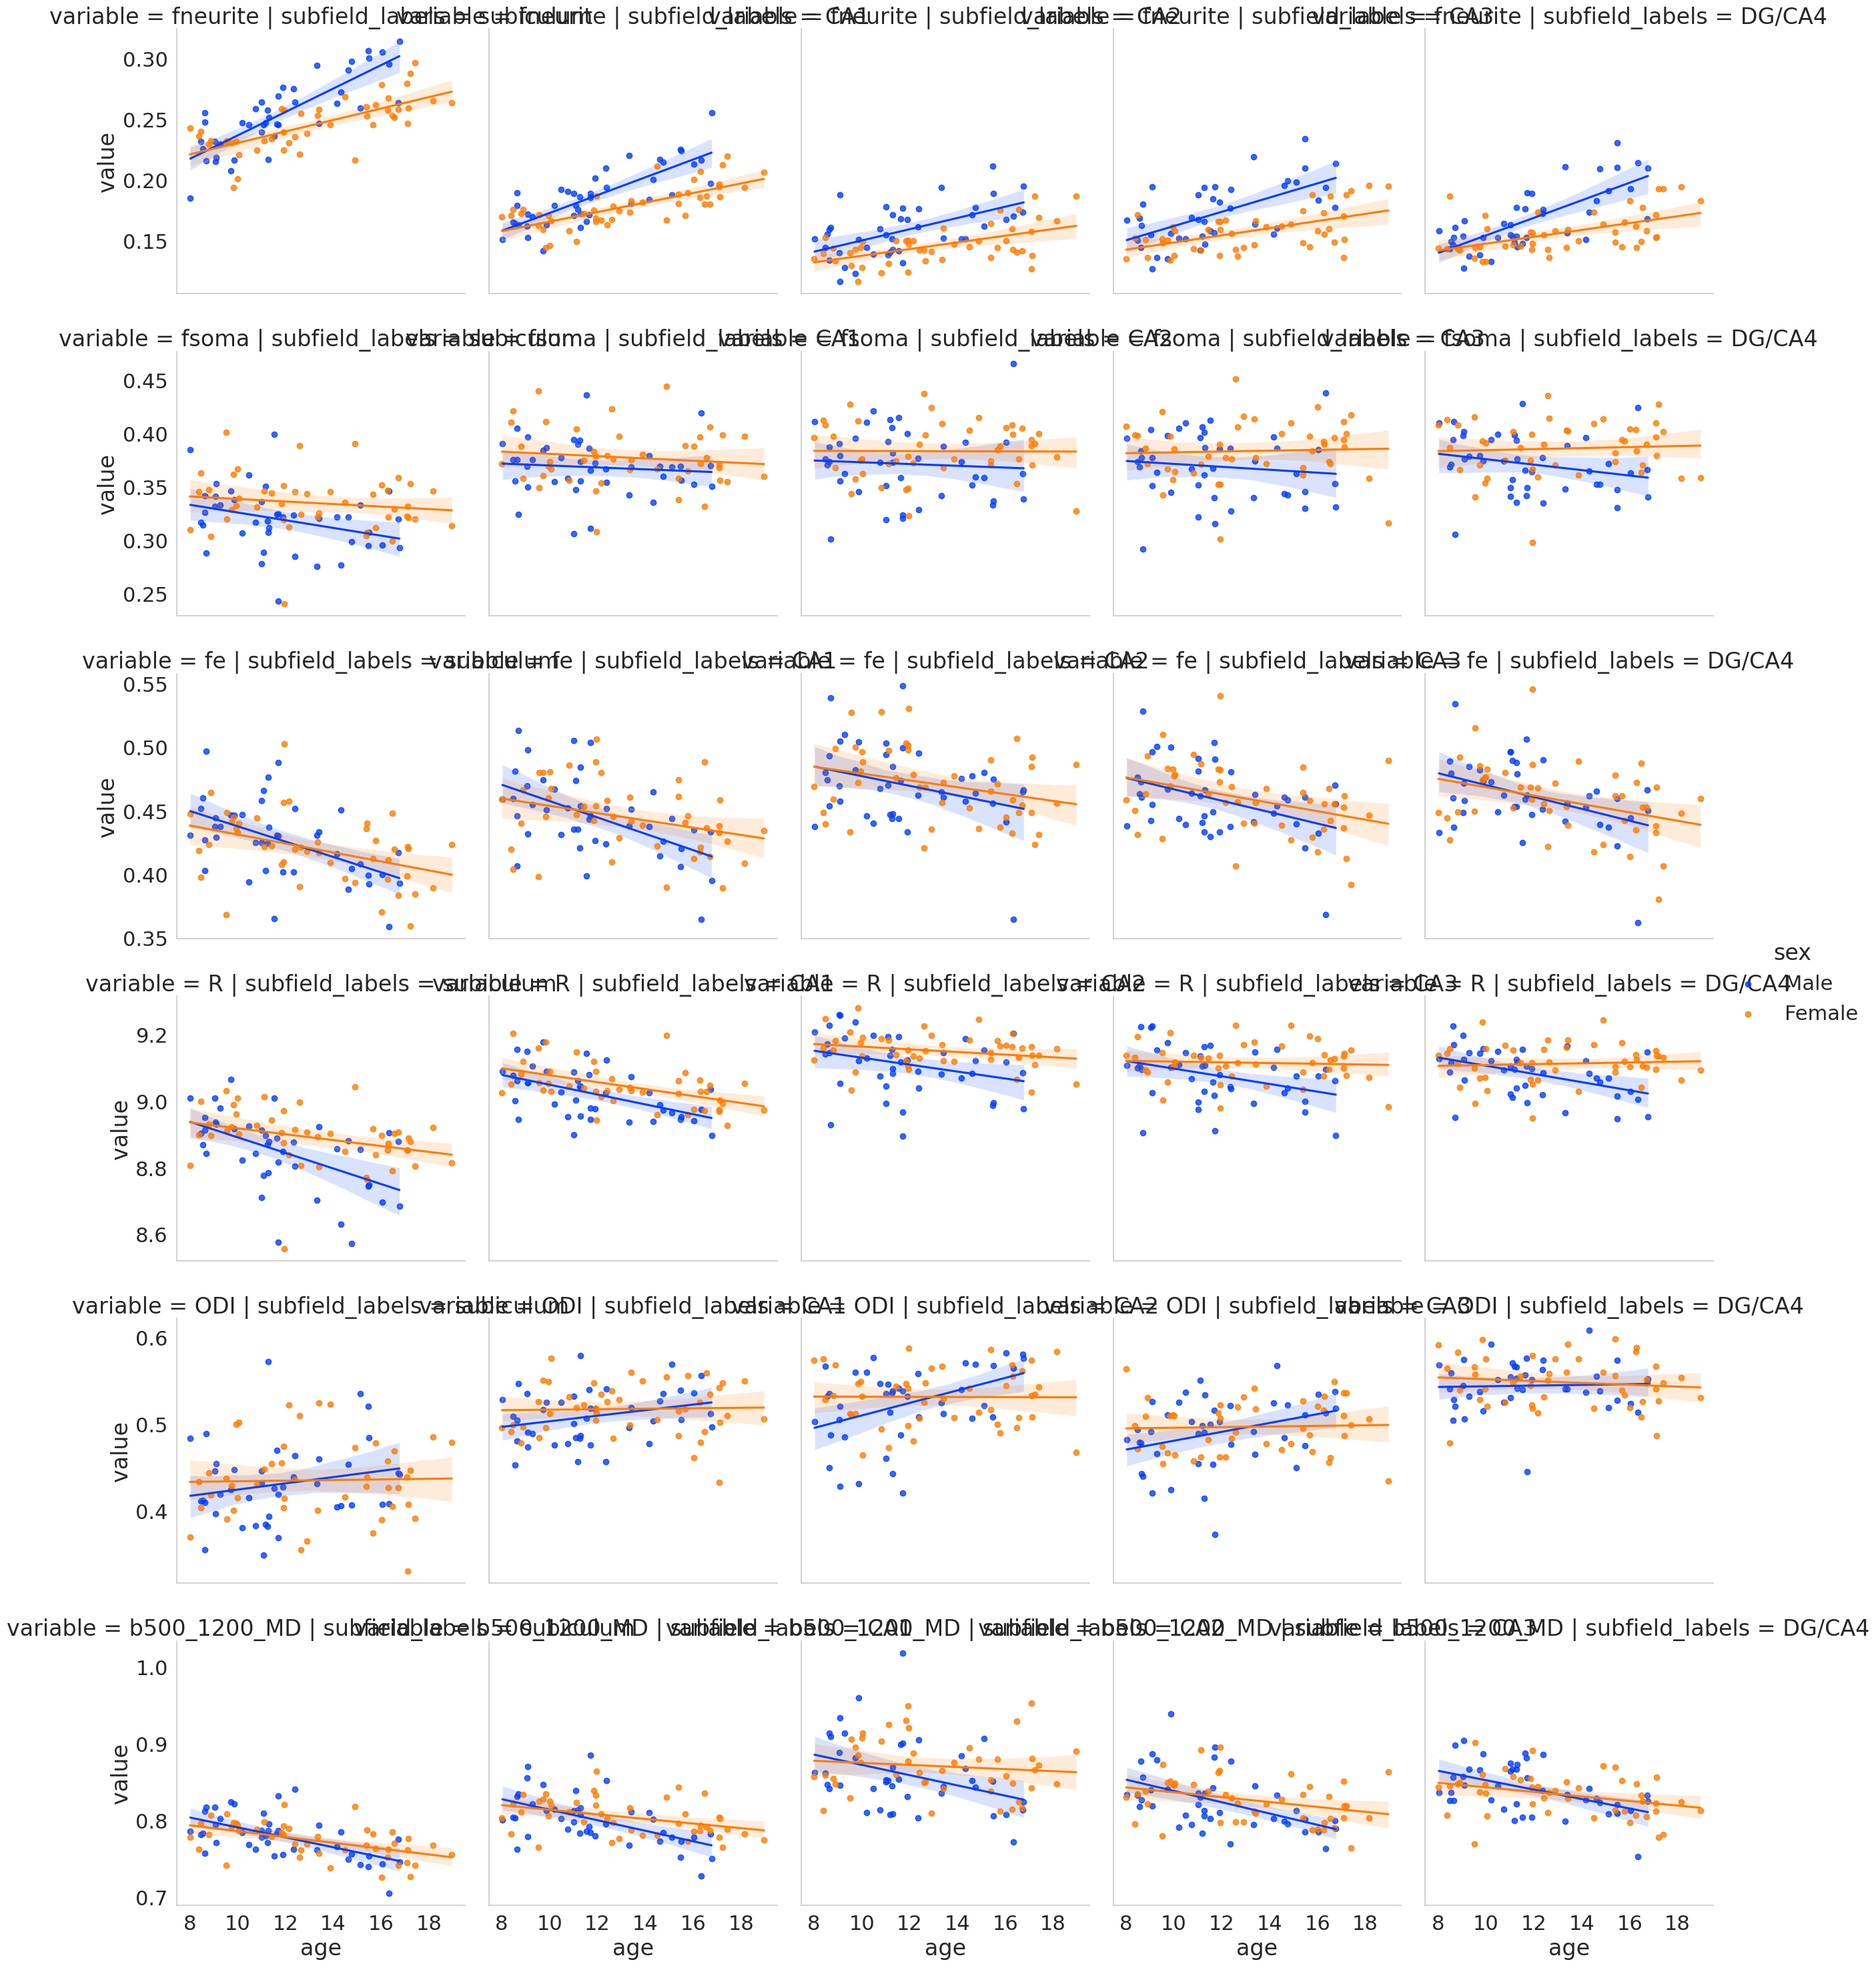

In [27]:
sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})

lm = sns.lmplot(x="age", y='value', data=dfplot,row='variable',col='subfield_labels',hue='sex',palette='bright',order=1,facet_kws={'sharey': 'row','sharex':True})
plt.xticks([8,10,12,14,16,18]) 
plt.show()

### Nested age:sex interaction

In [24]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
lm3 = smf.ols(formula='fneurite ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm4 = smf.ols(formula='fneurite ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels) + age:C(sex)', data=dfcomb).fit()

anovaResults = anova_lm(lm3,lm4)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff          F        Pr(>F)
0     425.0  0.111454      0.0       NaN        NaN           NaN
1     424.0  0.101108      1.0  0.010346  43.385889  1.333675e-10


In [25]:
lm3 = smf.ols(formula='fsoma ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm4 = smf.ols(formula='fsoma ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels) + age:C(sex)', data=dfcomb).fit()

anovaResults = anova_lm(lm3,lm4)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     425.0  0.327544      0.0       NaN       NaN       NaN
1     424.0  0.325492      1.0  0.002052  2.672875  0.102814


In [93]:
lm3 = smf.ols(formula='fe ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm4 = smf.ols(formula='fe ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels) + age:C(sex)', data=dfcomb).fit()

anovaResults = anova_lm(lm3,lm4)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff        F  Pr(>F)
0     425.0  0.302500      0.0       NaN      NaN     NaN
1     424.0  0.299318      1.0  0.003183  4.50875  0.0343


In [94]:
lm3 = smf.ols(formula='R ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm4 = smf.ols(formula='R ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels) + age:C(sex)', data=dfcomb).fit()

anovaResults = anova_lm(lm3,lm4)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff          F    Pr(>F)
0     425.0  2.144095      0.0       NaN        NaN       NaN
1     424.0  2.062289      1.0  0.081806  16.819101  0.000049


In [95]:
lm3 = smf.ols(formula='ODI ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm4 = smf.ols(formula='ODI ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels) + age:C(sex)', data=dfcomb).fit()

anovaResults = anova_lm(lm3,lm4)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff          F    Pr(>F)
0     425.0  0.542144      0.0       NaN        NaN       NaN
1     424.0  0.529175      1.0  0.012969  10.391724  0.001364


In [ ]:
lm3 = smf.ols(formula='b500_1200_MD ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm4 = smf.ols(formula='b500_1200_MD ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels) + age:C(sex)', data=dfcomb).fit()

anovaResults = anova_lm(lm3,lm4)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff          F    Pr(>F)
0     425.0  0.382488      0.0       NaN        NaN       NaN
1     424.0  0.370053      1.0  0.012434  14.247108  0.000183


### FDR correction of all above p-values

In [74]:
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests

print(fdrcorrection([1.333675e-10,0.102814,0.0343,0.000049,0.001364,0.000183]))

(array([ True, False,  True,  True,  True,  True]), array([8.00205e-10, 1.02814e-01, 4.11600e-02, 1.47000e-04, 2.04600e-03,
       3.66000e-04]))


### Nested model for subfield:age interaction

In [66]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='fneurite ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='fneurite ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels) + age:(subfield_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  0.105262      0.0       NaN       NaN       NaN
1     424.0  0.101108      4.0  0.004153  4.354372  0.001841


In [12]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='fsoma ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='fsoma ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels) + age:(subfield_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  0.327062      0.0       NaN       NaN       NaN
1     424.0  0.325492      4.0  0.001569  0.511108  0.727607


In [104]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='fe ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='fe ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels) + age:(subfield_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  0.300092      0.0       NaN       NaN       NaN
1     424.0  0.299318      4.0  0.000775  0.274442  0.894442


In [109]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='R ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='R ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels) + age:(subfield_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  2.122330      0.0       NaN       NaN       NaN
1     424.0  2.062289      4.0  0.060041  3.086084  0.015947


In [106]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='ODI ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='ODI ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels) + age:(subfield_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  0.533357      0.0       NaN       NaN       NaN
1     424.0  0.529175      4.0  0.004182  0.837774  0.501711


In [ ]:
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

lm1 = smf.ols(formula='b500_1200_MD ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='b500_1200_MD ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels) + age:(subfield_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  0.371033      0.0       NaN       NaN       NaN
1     424.0  0.370053      4.0  0.000979  0.280473  0.890598


### FDR correction of above p-values

In [14]:
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests

print(fdrcorrection([0.001841,0.727607,0.894442,0.015947,0.501711,0.890598]))

(array([ True, False, False,  True, False, False]), array([0.011046, 0.894442, 0.894442, 0.047841, 0.894442, 0.894442]))
